#### <b>Load Required Libraries</b>

In [1]:
!git clone https://github.com/ndb796/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST
%cd PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets

Cloning into 'PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 6094 (delta 41), reused 0 (delta 0), pack-reused 6014
Receiving objects: 100% (6094/6094), 640.19 MiB | 38.24 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Checking out files: 100% (5011/5011), done.
/content/PyTorch-Adversarial-Attack-Baselines-for-ImageNet-CIFAR10-MNIST/datasets


In [2]:
# load required PyTorch libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

#### <b>Load ImageNet Classes</b>

In [4]:
from urllib.request import urlretrieve
import json

# load 1,000 labels from the ImageNet config file
with open('./imagenet.json') as f:
    imagenet_labels = json.load(f)

print(imagenet_labels[18])

magpie


#### <b>Image Visualization</b>

In [6]:
imsize = 224

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # resize the image size
    transforms.ToTensor(), # [0, 255] → [0, 1] torch.Tensor
])

In [7]:
# load an image visualization library
import matplotlib.pyplot as plt
import PIL

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

In [8]:
# load an image and get a torch.Tensor object
def image_loader(path):
    image = PIL.Image.open(path)
    image = preprocess(image).unsqueeze(0) # [1, 3, H, W]
    return image.to(device, torch.float)

In [9]:
image = image_loader('./ILSVRC2012_img_val_subset/18/ILSVRC2012_val_00000476.JPEG')

In [10]:
# show torch.Tensor image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0) # [3, H, W]
    image = transforms.ToPILImage()(image)
    # show an image whose values are between [0, 1]
    plt.imshow(image)
    plt.show()

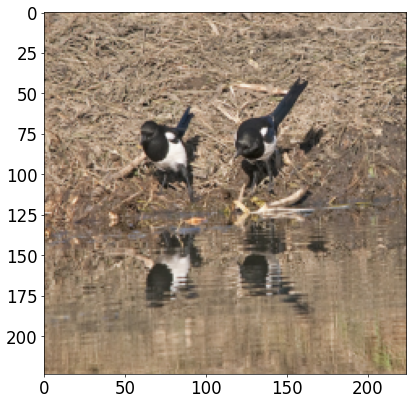

In [11]:
imshow(image)

#### <b>Load Pre-trained Classification Model</b>

In [12]:
# input data normalization class
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [13]:
model = nn.Sequential(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # add an input normalization layer
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
).to(device).eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [14]:
outputs = model(image)
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print("< Highest Confidence Classes >")
for i in outputs[0].topk(5)[1]:
    print(f"Index: {i.item()} / Class name: {imagenet_labels[i]} / Probability: {round(percentages[i].item(), 4)}%")

< Highest Confidence Classes >
Index: 18 / Class name: magpie / Probability: 76.3741%
Index: 80 / Class name: black grouse / Probability: 17.3179%
Index: 137 / Class name: American coot, marsh hen, mud hen, water hen, Fulica americana / Probability: 1.0765%
Index: 93 / Class name: hornbill / Probability: 0.6028%
Index: 128 / Class name: black stork, Ciconia nigra / Probability: 0.5908%


#### <b>Load Validation Dataset</b>

In [15]:
import os
from torchvision import datasets

data_dir = './ILSVRC2012_img_val_subset'

val_dataset = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
print('Validation dataset size:', len(val_dataset))

class_names = val_dataset.classes
print('The number of classes:', len(class_names))

Validation dataset size: 5000
The number of classes: 1000


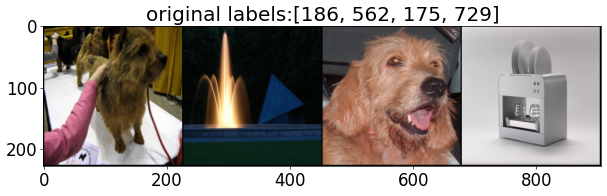

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: Norwich terrier (186)
Image #2: fountain (562)
Image #3: otterhound, otter hound (175)
Image #4: plate rack (729)


In [16]:
import torchvision
import numpy as np


def imshow_batch(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of validation image
iterator = iter(val_dataloader)

# visualize a batch of validation image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow_batch(out, title='original labels:' + str([int(class_names[x]) for x in classes[:4]]))

print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
for i, x in enumerate(classes[:4]):
    imagenet_index = int(class_names[x])
    label = imagenet_labels[imagenet_index]
    print(f'Image #{i + 1}: {label} ({imagenet_index})')

#### <b>Validation Phase</b>

[Prediction Result Examples]


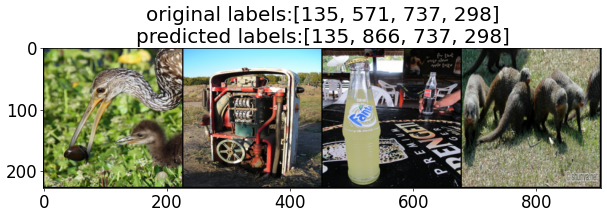

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: limpkin, Aramus pictus (135)
Image #2: gas pump, gasoline pump, petrol pump, island dispenser (571)
Image #3: pop bottle, soda bottle (737)
Image #4: mongoose (298)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: limpkin, Aramus pictus (135)
Image #2: tractor (866)
Image #3: pop bottle, soda bottle (737)
Image #4: mongoose (298)


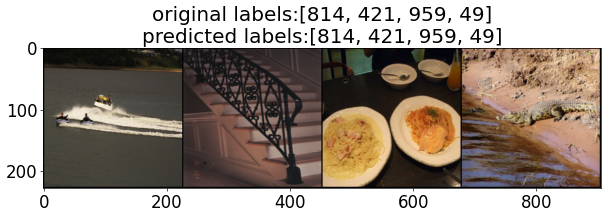

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: speedboat (814)
Image #6: bannister, banister, balustrade, balusters, handrail (421)
Image #7: carbonara (959)
Image #8: African crocodile, Nile crocodile, Crocodylus niloticus (49)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: speedboat (814)
Image #6: bannister, banister, balustrade, balusters, handrail (421)
Image #7: carbonara (959)
Image #8: African crocodile, Nile crocodile, Crocodylus niloticus (49)
[Validation] Loss: 0.0619 Accuracy: 76.0600% Time elapsed: 34.0647s (total 5000 images)


In [17]:
import time

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, basic_labels) in enumerate(val_dataloader):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                         '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

#### <b>Prepare Adversarial Attack Libraries</b>

In [18]:
!pip install foolbox
!pip install advertorch

In [19]:
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

#### <b>Adversarial Attack Example</b>

* <b>Attack method</b>: L2 CW
* <b>Options</b>: 100 iterations
* <b>Images</b>: 5,000 valiation images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


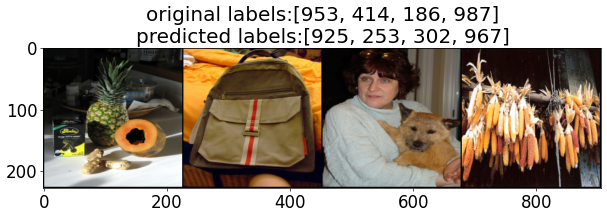

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: pineapple, ananas (953)
Image #2: backpack, back pack, knapsack, packsack, rucksack, haversack (414)
Image #3: Norwich terrier (186)
Image #4: corn (987)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: consomme (925)
Image #2: basenji (253)
Image #3: ground beetle, carabid beetle (302)
Image #4: espresso (967)


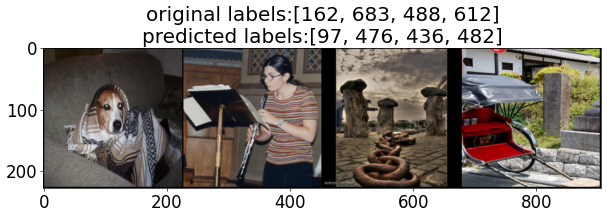

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: beagle (162)
Image #6: oboe, hautboy, hautbois (683)
Image #7: chain (488)
Image #8: jinrikisha, ricksha, rickshaw (612)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: drake (97)
Image #6: carousel, carrousel, merry-go-round, roundabout, whirligig (476)
Image #7: beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon (436)
Image #8: cassette player (482)
[Step #0] Loss: 0.2039 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 30.2547s (total 16 images)
[Step #10] Loss: 0.2246 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 270.2091s (total 176 images)
[Step #20] Loss: 0.2301 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 479.8567s (total 336 images)
[Step #30] Loss: 0.2357 Accuracy: 0.2016% Attack success rate: 100.0000% Time elapsed: 671.8201s (total 496 images)
[Step #40] Loss: 0.2340 Accuracy: 0.1524% Attack success rate: 100.0000% Time elapsed: 895.6988

In [26]:
import time
from advertorch.attacks import CarliniWagnerL2Attack

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

adversary = CarliniWagnerL2Attack(
    model, num_classes=1000, confidence=0, targeted=True,
    learning_rate=0.01, binary_search_steps=4, max_iterations=100, abort_early=True,
    initial_const=0.001, clip_min=0.0, clip_max=1.0)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    target_labels = torch.randint(0, 1000, (labels.shape[0], )).to(device) # random targets
    adv_targeted = adversary.perturb(inputs, target_labels) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
epoch_asr = running_success / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

#### <b>Comparison with Foolbox</b>

* <b>Attack method</b>: L2 CW
* <b>Options</b>: 100 iterations
* <b>Images</b>: 5,000 valiation images

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


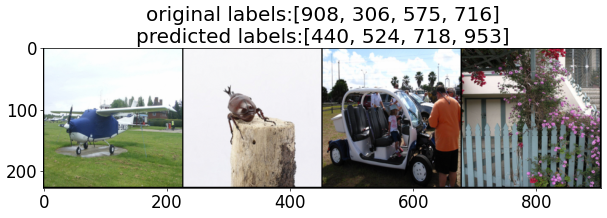

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: wing (908)
Image #2: rhinoceros beetle (306)
Image #3: golfcart, golf cart (575)
Image #4: picket fence, paling (716)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: beer bottle (440)
Image #2: cuirass (524)
Image #3: pier (718)
Image #4: pineapple, ananas (953)


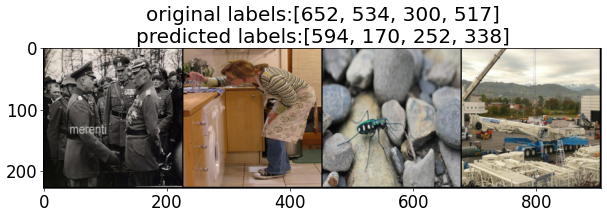

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: military uniform (652)
Image #6: dishwasher, dish washer, dishwashing machine (534)
Image #7: tiger beetle (300)
Image #8: crane (517)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: harp (594)
Image #6: Irish wolfhound (170)
Image #7: affenpinscher, monkey pinscher, monkey dog (252)
Image #8: guinea pig, Cavia cobaya (338)
[Step #0] Loss: 0.1917 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 25.1935s (total 16 images)
[Step #10] Loss: 0.2221 Accuracy: 0.0000% Attack success rate: 100.0000% Time elapsed: 232.2690s (total 176 images)
[Step #20] Loss: 0.2316 Accuracy: 0.0000% Attack success rate: 99.7024% Time elapsed: 437.8229s (total 336 images)
[Step #30] Loss: 0.2295 Accuracy: 0.0000% Attack success rate: 99.7984% Time elapsed: 658.6067s (total 496 images)
[Step #40] Loss: 0.2315 Accuracy: 0.0000% Attack success rate: 99.8476% Time elapsed: 859.0371s (total 656 images)
[Step #50] Loss: 0.2293 Accuracy: 0.0000% A

In [27]:
import time
import foolbox as fb

criterion = nn.CrossEntropyLoss()
model.eval()
start_time = time.time()

fmodel = fb.PyTorchModel(model, bounds=(0, 1))
attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps=4, steps=100, stepsize=0.01, confidence=0, initial_const=0.001, abort_early=True)

running_loss = 0.
running_corrects = 0
running_success = 0
running_length = 0

running_l0 = 0
running_l2 = 0
running_mse = 0
running_linf = 0

for i, (inputs, basic_labels) in enumerate(val_dataloader):
    inputs = inputs.to(device)
    labels = torch.zeros_like(basic_labels).long().to(device)
    for j in range(labels.shape[0]):
        labels[j] = int(class_names[basic_labels[j]])
    labels = labels.to(device)

    target_labels = torch.randint(0, 1000, (labels.shape[0], )).to(device) # random targets
    attack_criterion = fb.criteria.TargetedMisclassification(target_labels)
    _, adv_targeted, _ = attack(fmodel, inputs, criterion=attack_criterion, epsilons=None) # adversarial attack

    outputs = model(adv_targeted)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
    running_success += torch.sum(preds == target_labels.data)
    running_length += labels.shape[0]

    l0, l2, mse, linf = get_distance(adv_targeted, inputs)
    running_l0 += l0.sum().item()
    running_l2 += l2.sum().item()
    running_mse += mse.sum().item()
    running_linf += linf.sum().item()

    if i == 0:
        print('The dimension of an image tensor:', inputs.shape[1:])
        print('[Prediction Result Examples]')
        images = torchvision.utils.make_grid(adv_targeted[:4])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[:4]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[:4]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 1}: {label} ({imagenet_index})')
        images = torchvision.utils.make_grid(adv_targeted[4:8])
        imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                      '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
        print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(labels[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')
        print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
        for j, imagenet_index in enumerate(preds[4:8]):
            label = imagenet_labels[imagenet_index]
            print(f'Image #{j + 5}: {label} ({imagenet_index})')

    if i % 10 == 0:
        cur_running_loss = running_loss / running_length
        running_acc = running_corrects / running_length * 100.
        running_asr = running_success / running_length * 100.
        print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, running_asr, time.time() - start_time, running_length))

epoch_loss = running_loss / len(val_dataset)
epoch_acc = running_corrects / len(val_dataset) * 100.
epoch_asr = running_success / len(val_dataset) * 100.
print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Attack success rate: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, epoch_asr, time.time() - start_time, len(val_dataset)))

print('[Size of Perturbation]')
print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
print('Average L2 distance:', running_l2 / len(val_dataset))
print('Average MSE:', running_mse / len(val_dataset))
print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))